<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/migration_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook for processing particle simulator results
(launched from github)

* Upload csv files from working directory to DL:
e.g.
> cp $FAUST:/home/pkekeneshuskey/source/cellmigration/run/231129/test.png.csv ~/DL/

or

> cp /home/pkekeneshuskey/source/cellmigration/run/231129/test.png.csv ~/DL/

* mount google drive to write data (just hit google drive button under Files)


* Hop to [section](#myCell) to process


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# mount drive 1st (just for storing output images)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
outPath='/content/drive/MyDrive/temp/231212/'
if os.path.exists(outPath) is False:
  raise RuntimeError("Be sure to mount google drive")

In [5]:
!git clone https://github.com/huskeypm/cellmigration
#!cd /content/cellmigration; git pull


Cloning into 'cellmigration'...
remote: Enumerating objects: 809, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 809 (delta 109), reused 101 (delta 100), pack-reused 684
Receiving objects: 100% (809/809), 13.06 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (516/516), done.


In [6]:
import sys
sys.path.append('/content/cellmigration')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import processData as pdat
cases = dict()
class empty:pass

Partition file according to cases

In [16]:
dataFrameName = outPath+"all.csv"
#dataFrameName="all.csv"
df = pd.read_csv(dataFrameName)

# get number of cases
ex = 'nocrowder_nocontainment_xScale0.000000_'#assuming ends w 00,01,..0X
nCases = len(df.query('trajName.str.startswith("%s")'%ex))
print("We found %d runs per case"%nCases)

We found 5 runs per case


In [17]:
### pull out those without ATP in the title
#new_df = df[~df["col"].str.contains(word)]

nocrowder_unconstr = df.loc[
     df['trajName'].str.contains("nocrowder_nocontainment")  &
    ~df['trajName'].str.contains("atp")
]


nocrowder_noatp = df.loc[
     df['trajName'].str.contains("nocrowder")  &
    ~df['trajName'].str.contains("atp")
]

nocrowder_atp = df.loc[
     df['trajName'].str.contains("nocrowder")  &
     df['trajName'].str.contains("atp")
]

crowder_noatp = df.loc[
     df['trajName'].str.contains("^crowder")  &
    ~df['trajName'].str.contains("atp")
]
#print(crowder_noatp.tail())

crowder_atp = df.loc[
     df['trajName'].str.contains("^crowder")  &
     df['trajName'].str.contains("atp")
]


In [18]:
df.loc[
     df['trajName'].str.contains("nocrowder") ]

,Unnamed: 0,trajName,tag,condVal,D,flux*A(reservoir),flux*A(crowd),Vol Frac,Area Frac
223,0,nocrowder_atp_cellAttr0.050000_00,cellAttr,0.05,0.000007,-7.605973e-07,-6.016937e-10,0.999997,0.946881
224,0,nocrowder_atp_cellAttr0.050000_01,cellAttr,0.05,0.000039,-7.728295e-07,-5.487167e-10,0.999997,0.945034
225,0,nocrowder_atp_cellAttr0.050000_02,cellAttr,0.05,-0.000097,-8.494892e-07,-5.156508e-10,0.999997,0.936034
226,0,nocrowder_atp_cellAttr0.050000_03,cellAttr,0.05,0.000030,-7.496969e-07,-5.286281e-10,0.999997,0.939259
227,0,nocrowder_atp_cellAttr0.050000_04,cellAttr,0.05,-0.000062,-7.430520e-07,-5.717936e-10,0.999997,0.952409
...,...,...,...,...,...,...,...,...,...
618,0,nocrowder_nocontainment_xScale0.000000_00,xScale,0.00,0.925943,-3.137859e-07,2.741238e-08,0.999997,0.362106
619,0,nocrowder_nocontainment_xScale0.000000_01,xScale,0.00,0.806456,-3.978245e-07,4.303394e-08,0.999997,0.407166
620,0,nocrowder_nocontainment_xScale0.000000_02,xScale,0.00,1.163383,-2.771831e-07,3.924223e-08,0.999997,0.378041
621,0,nocrowder_nocontainment_xScale0.000000_03,xScale,0.00,0.902040,-4.624578e-07,3.308738e-08,0.999997,0.370025


### Case: no crowders

In [13]:
dataFrameName = "fig4.csv"
dataFrameName = "nocrowder.csv"

if False:
  df = pd.read_csv(dataFrameName)
else:
  df = nocrowder_noatp


Determine normalization for all cases

In [14]:
key = "nCells"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.JAstds, case.vFs = pdat.ProcessGroup(df,key)

# get JA at largest vol frac
idx = np.argmax(case.vFs)
jNormFactor = 1/case.JAs[ idx ]
def hs(vf):
  return 2*vf/(3-vf)
jNormFactor*=hs( case.vFs[idx] )

case.JAs[ idx ]
print(jNormFactor)

nCells [30. 40. 50. 60. 70. 80. 90.]
-1364282.4406630632


nCells [30. 40. 50. 60. 70. 80. 90.]


(0.0, 1.05)

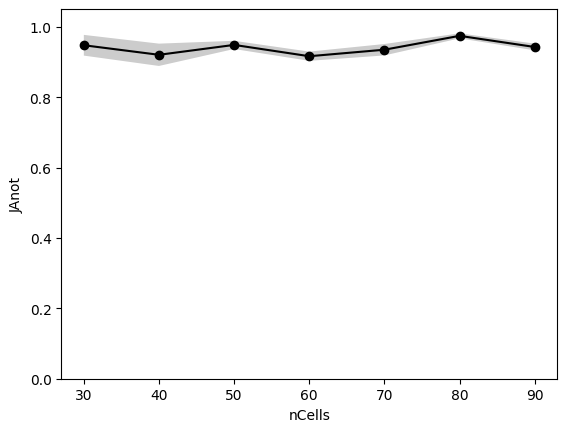

In [ ]:

# get all entries with a given key name
key = "nCells"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs, case.JAstds,  case.vFs = pdat.ProcessGroup(df,key)
cases[key] = case

stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,mode="JA")
plt.ylim([0,1.05])


In [ ]:
provide mean position for uncontains cases

### Introduce ATP into the equation

 <a class="anchor" name="myCell"></a>



In [ ]:
import pandas as pd
if False:
  dataFrameName = "nocrowder.csv"
  df = pd.read_csv(dataFrameName)
  dataFrameName = "nocrowder_atp.csv"
  dfATP = pd.read_csv(dataFrameName)
else:
  df = nocrowder_noatp
  dfATP=nocrowder_atp


In [ ]:
dfATP

,Unnamed: 0,trajName,tag,condVal,D,flux*A(reservoir),flux*A(crowd),Vol Frac,Area Frac
168,0,nocrowder_atp_cellAttr0.050000_00,cellAttr,0.05,0.000007,-7.605973e-07,-6.016937e-10,0.999997,0.946881
169,0,nocrowder_atp_cellAttr0.050000_01,cellAttr,0.05,0.000039,-7.728295e-07,-5.487167e-10,0.999997,0.945034
170,0,nocrowder_atp_cellAttr0.050000_02,cellAttr,0.05,-0.000097,-8.494892e-07,-5.156508e-10,0.999997,0.936034
171,0,nocrowder_atp_cellAttr0.050000_03,cellAttr,0.05,0.000030,-7.496969e-07,-5.286281e-10,0.999997,0.939259
172,0,nocrowder_atp_cellAttr0.050000_04,cellAttr,0.05,-0.000062,-7.430520e-07,-5.717936e-10,0.999997,0.952409
...,...,...,...,...,...,...,...,...,...
344,0,nocrowder_atp_yScale7.000000_00,yScale,7.00,0.000039,-7.733884e-07,-5.593184e-10,0.999997,0.943428
345,0,nocrowder_atp_yScale7.000000_01,yScale,7.00,0.000058,-8.463665e-07,-4.688464e-10,0.999997,0.945156
346,0,nocrowder_atp_yScale7.000000_02,yScale,7.00,0.000015,-7.766710e-07,-5.782919e-10,0.999997,0.944619
347,0,nocrowder_atp_yScale7.000000_03,yScale,7.00,0.000161,-7.660951e-07,-5.059465e-10,0.999997,0.950922


all [0.]
xScale [0. 1. 2. 3. 4. 5. 6. 7.]


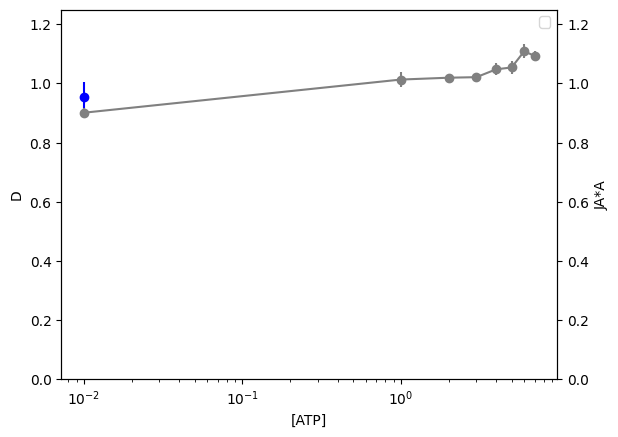

In [ ]:
#if 1: # for right now
case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.JAstds,case.volFracs = pdat.ProcessGroup(nocrowder_unconstr,'all')
cases["unconstr"] = case

case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.JAstds,case.volFracs = pdat.ProcessGroup(dfATP,"xScale")
cases["constr"] = case

#dfATP.xScale
fig,axl = plt.subplots()
case = cases["unconstr"]

thresh = 1e-2
case.conds[case.conds<thresh]=thresh. # so we can plot log scale

#axl.plot(case.conds,case.Ds,label='D')
#axr.err(case.conds,case.Dstds/np.sqrt(nCases))
axl.errorbar(case.conds,case.Ds,
            yerr=case.Dstds / np.sqrt(nCases),
            fmt='-o',color='blue')
axl.set_ylabel("D")
axl.set_xlabel("[ATP]")
axl.legend(loc=0)
axl.set_ylim([0,1.25])


# we use negative -1 since negative flux is going across toward right
axr = axl.twinx()
case = cases["constr"]
case.conds[case.conds<thresh]=thresh
stds = case.JAstds*-1*jNormFactor
#axr.plot(case.conds,case.JAs*jNormFactor,'gray')
axr.errorbar(case.conds,case.JAs*jNormFactor,
             yerr=stds/ np.sqrt(nCases),
             fmt='-o',color='gray')
axr.set_ylabel("JA*A")
axr.set_ylim([0,1.25])
axr.set_xscale('log')
plt.gcf().savefig(outPath+"fig4_D_vs_ATP.png",dpi=300)

[30. 40. 50. 60. 70. 80. 90.]
[30. 40. 50. 60. 70. 80. 90.]
Assuming middle value is reference
x(3) = 60.000000
Assuming middle value is reference
x(3) = 60.000000


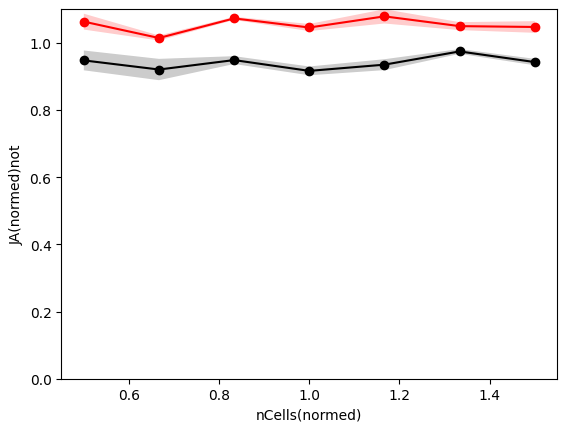

In [ ]:
# plotting two sets of data
# get all entries with a given key name
key = "nCells"

case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.JAstds, case.vFs = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case

print("WARNING: using incorrect stderr")
case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,normalize=True,mode="JA")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=True,mode="JA")
plt.ylim([0,1.1])
plt.gcf().savefig(outPath+"fig4_nCells.png",dpi=300)


[2.         2.5198421  3.1748021  4.         5.0396842  6.34960421
 8.        ]
[2.         2.5198421  3.1748021  4.         5.0396842  6.34960421
 8.        ]
Assuming middle value is reference
x(3) = 4.000000
Assuming middle value is reference
x(3) = 4.000000


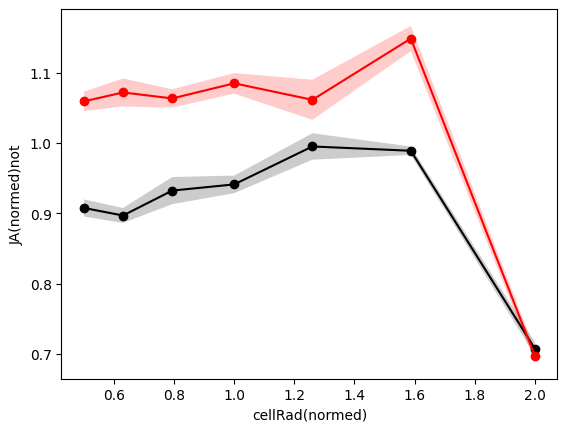

In [ ]:

key = "cellRad"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='k',normalize=True,mode="JA")


case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=True,mode="JA")


plt.gcf().savefig(outPath+"fig4_cellRad.png",dpi=300)

cellAttr [0.05       0.06299605 0.07937005 0.1        0.1259921  0.15874011
 0.2       ]
cellAttr [0.05       0.06299605 0.07937005 0.1        0.1259921  0.15874011
 0.2       ]
Assuming middle value is reference
x(3) = 0.100000
Assuming middle value is reference
x(3) = 0.100000


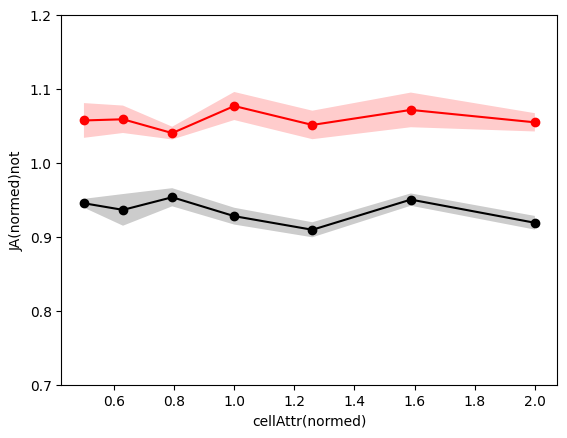

In [ ]:
key = "cellAttr"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='k',normalize=True,mode="JA")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=True,mode="JA")
plt.ylim([0.7,1.2])
plt.xscale('log')
plt.gcf().savefig(outPath+"fig4_cellAttr.png",dpi=300)

yScale [0. 1. 2. 3. 4. 5. 6. 7.]
Assuming middle value is reference
x(4) = 4.000000


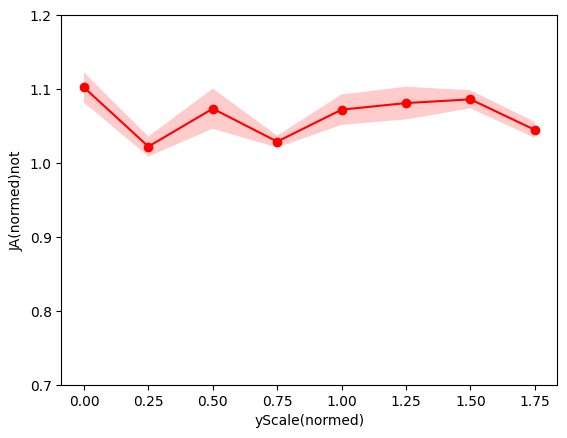

In [ ]:
key = "yScale"

#case = empty()
#case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
#cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


#case = cases[key+"-atp"]
#stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
#pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='k',normalize=True,mode="JA")


case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=True,mode="JA")
plt.ylim([0.7,1.2])
plt.xscale('log')
plt.gcf().savefig(outPath+"fig4_yScale.png",dpi=300)

Need to upload csv files
nocrowder_atp_nCells70.000000_04prob.csv

In [ ]:
prob    = np.loadtxt(outPath+"/nocrowder_nCells70.000000_04prob.csv")
probATP = np.loadtxt(outPath+"/nocrowder_atp_nCells70.000000_04prob.csv")

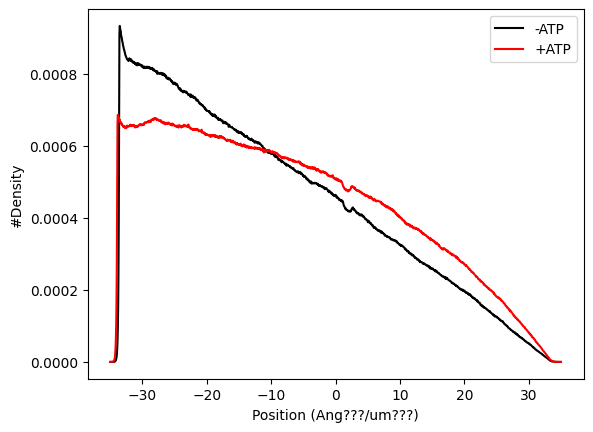

In [ ]:
Ang_to_um = 0.1
xs = np.linspace(-350*Ang_to_um,350*Ang_to_um,1400)
oneD  = np.sum(prob,axis=1)
plt.plot(xs,oneD,'k',label='-ATP')
oneDATP = np.sum(probATP,axis=1)
plt.plot(xs,oneDATP,'r',label='+ATP')
plt.ylabel('#Density')
plt.xlabel('Position (Ang???/um???)')
plt.legend(loc=0)
plt.gcf().savefig(outPath+'profile.png',dpi=300)

## CROWDERS WITH ATP

In [11]:
if False:
  dataFrameName = "crowder.csv"
  df = pd.read_csv(dataFrameName)
  dataFrameName = "crowder_atp.csv"
  dfATP = pd.read_csv(dataFrameName)
else:
  df = crowder_noatp
  dfATP = crowder_atp



nCrowders [ 1.  4. 18.]
nCrowders [ 1.  4. 18.]


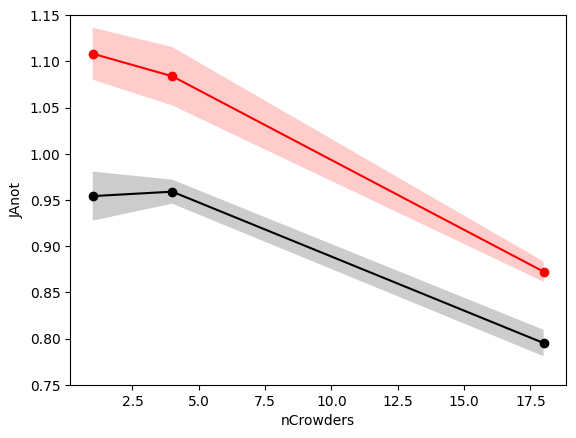

In [ ]:
key = "nCrowders"

case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds, case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case



case = cases[key+"-atp"]
#PlotKey(case.conds,case.Ds,case.Dstds,key,normalize=False)
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='k',normalize=False,mode="JA")

case = cases[key+"+atp"]
#PlotKey(case.conds,case.Ds,case.Dstds,key,color='r',normalize=False)
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=False,mode="JA")
plt.ylim([0.75,1.15])

plt.gcf().savefig(outPath+"fig5_nCrowders.png",dpi=300)


crowderRad [ 0.1  1.   3.   5.   7.   9.  10. ]
JAs [-6.87921953e-07 -6.49651814e-07 -6.58211763e-07 -6.46795168e-07
 -6.29291906e-07 -6.00082000e-07 -5.87193874e-07] [0.93851984 0.88630856 0.89798675 0.88241129 0.8585319  0.81868133
 0.80109829]
NEED TO ADJUST FOR ACTUAL CALCULTION 
crowderRad [ 0.1  1.   3.   5.   7.   9.  10. ]


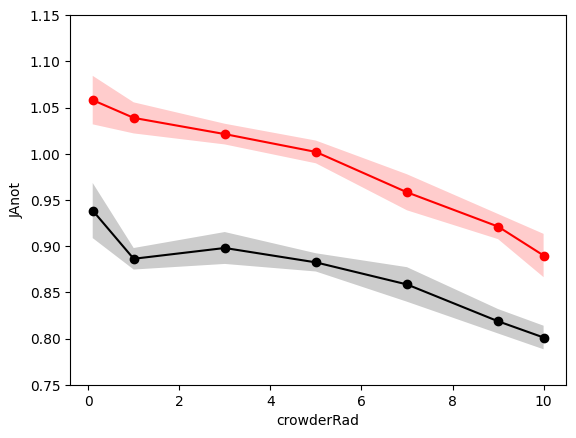

In [ ]:
key = "crowderRad"

vfs = np.linspace(0.6,1.,20)
hs = 2*vfs/(3-vfs)


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case

#print('JAs',case.JAs)
print('JAs',case.JAs, case.JAs*jNormFactor)
print("NEED TO ADJUST FOR ACTUAL CALCULTION ")

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case
#print('+ATP JAs',case.JAs*jNormFactor)

case = cases[key+"-atp"]
#pdat.PlotKey(case.conds,case.Ds,stds,key,normalize=False)
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,normalize=False,mode="JA")

case = cases[key+"+atp"]
#pdat.PlotKey(case.conds,case.Ds,case.Dstds,key,color='r',normalize=False)
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=False,mode="JA")
plt.ylim([0.75,1.15])



plt.gcf().savefig(outPath+"fig5_crowderRad.png",dpi=300)



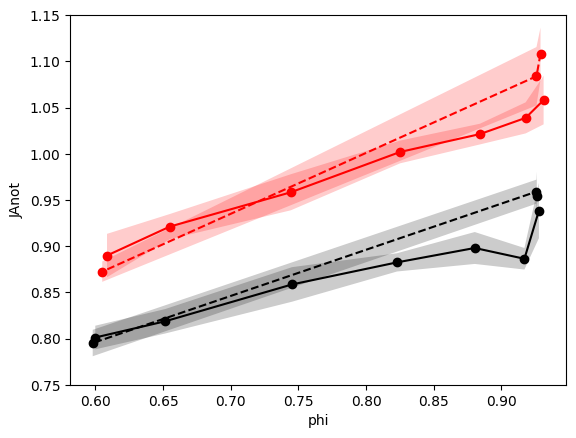

In [ ]:

key = "crowderRad"
case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,"phi",normalize=False,mode="JA")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,"phi",color='r',normalize=False,mode="JA")

key = "nCrowders"
case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,"phi",color='k',style='--',normalize=False,mode="JA")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,"phi",color='r',style='--',normalize=False,mode="JA")


plt.ylim([0.75,1.15])


plt.gcf().savefig(outPath+"fig5_crowding_vf.png",dpi=300)



crowderAttr [5.00000000e-02 6.29960525e-02 7.93700526e-02 1.00000000e-01
 1.25992105e-01 1.58740105e-01 2.00000000e-01 2.00000000e+00
 4.00000000e+00 6.00000000e+00 1.00000000e+01 2.50000000e+01
 5.00000000e+01 7.50000000e+01 1.00000000e+02]
crowderAttr [5.00000000e-02 6.29960525e-02 7.93700526e-02 1.00000000e-01
 1.25992105e-01 1.58740105e-01 2.00000000e-01 1.00000000e+01
 2.50000000e+01 5.00000000e+01 7.50000000e+01 1.00000000e+02]


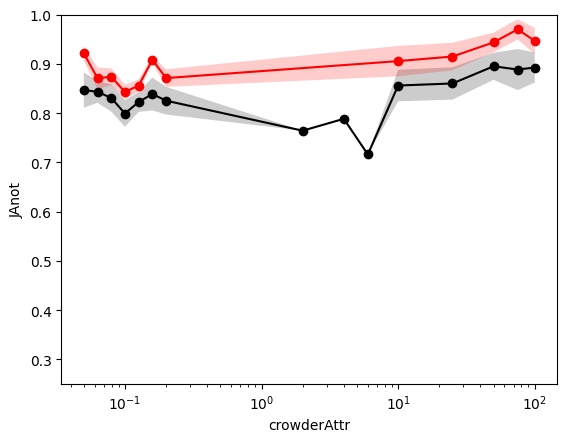

In [20]:
key = "crowderAttr"

case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(df,key)
cases[key+"-atp"] = case


case = empty()
case.conds,case.Ds,case.Dstds,case.JAs,case.JAstds, case.vFs  = pdat.ProcessGroup(dfATP,key)
cases[key+"+atp"] = case


case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,normalize=False,mode="JA")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.conds,case.JAs*jNormFactor,stds,key,color='r',normalize=False,mode="JA")

plt.ylim([0.25,1.0])
plt.xscale('log')
plt.gcf().savefig(outPath+"fig5_crowderAttr.png",dpi=300)

## Continuum data

- Run master on kant (test07-test10)
(https://bitbucket.org/huskeypm/diffusion_example_2d/src/master/requests/??????)

- See paper notes for more detail on repository

```
../solutions/test07/smol/0001/info.yaml:Deff_membrane: 0.49443361495120397
../solutions/test08/smol/0001/info.yaml:Deff_membrane: 0.7730293910002057
../solutions/test09/smol/0001/info.yaml:Deff_membrane: 0.7963113880422519
../solutions/test10/smol/0001/info.yaml:Deff_membrane: 0.9866307129197737
Singularity> grep phi_memb ../solutions/test*/smol/0001/info.yaml
../solutions/test07/smol/0001/info.yaml:phi_membrane: 0.6681145173651292
../solutions/test08/smol/0001/info.yaml:phi_membrane: 0.8539840575456275
../solutions/test09/smol/0001/info.yaml:phi_membrane: 0.8772177500681925
../solutions/test10/smol/0001/info.yaml:phi_membrane: 0.9933862126810031
```





<code>
///// reservoir on right (negative); next (positive); neutral; negative in channel
 0.11386163913859533 #(both particle and potential are negative?, so why is flux increased?)
 0.06720684392605135  
 0.07531812128985557
0.08490851205509801

conc higher on left in model
</code>

In [ ]:
import matplotlib.pylab as plt
import numpy as np
phis = np.array([0.4108862126810036, 0.6681145173651292, 0.8539840575456275, 0.8772177500681925, 0.9933862126810031])
Ds = np.array([0.403642231410656, 0.49443361495120397, 0.7730293910002057, 0.7963113880422519, 0.9866307129197737])

print("THESE ARE FLUXES, NOT Ds!!!!")
phisATPEnd = np.array([0.99]) ; print("WARNING: need to verify")
ref =  0.07531812128985557
DsATPEnd = np.array([0.11386163913859533])/ref ; print("WARNING: field and species are both negative/???")

phisATPSide = np.array([0.99]) ; print("WARNING: need to verify")
DsATPSide = np.array([0.08490851205509801])/ref ; print("WARNING: field and species are both negative/repulsive???")

phisRepulsiveEnd = np.array([0.99]) ; print("WARNING: need to verify")
DsRepulsiveEnd = np.array([0.06720684392605135])/ref ; print("WARNING: field and species are attractive???")



THESE ARE FLUXES, NOT Ds!!!!


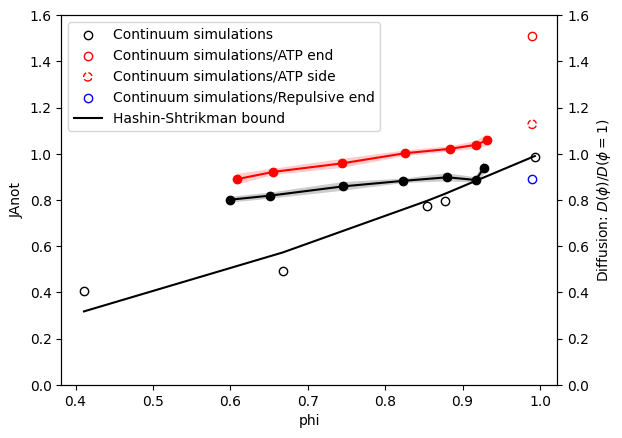

In [ ]:
daMax=1.60

key="crowderRad"
# particle
plt.figure()
case = cases[key+"-atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,key,normalize=False, mode="JA",altName="phi")

case = cases[key+"+atp"]
stds = case.JAstds*-1*jNormFactor / np.sqrt(nCases)
pdat.PlotKey(case.vFs,case.JAs*jNormFactor,stds,key,color='r',normalize=False,mode="JA",altName="phi")
plt.ylim([0,daMax])

## continuum
#fig,axl = plt.subplots(1)
axr = plt.twinx()
axr.scatter(phis,Ds,edgecolor='k', facecolor='w',label="Continuum simulations")


axr.scatter(phisATPEnd,DsATPEnd,edgecolor='r', facecolor='w',
            label="Continuum simulations/ATP end")
axr.scatter(phisATPSide,DsATPSide,edgecolor='r', facecolor='w',linestyle='--',
            label="Continuum simulations/ATP side")
axr.scatter(phisRepulsiveEnd,DsRepulsiveEnd,edgecolor='b', facecolor='w',
            label="Continuum simulations/Repulsive end")


# analytic
axr.plot(phis,2*phis/(3-phis),'k',label="Hashin-Shtrikman bound")

axr.set_xlabel("Free volume(area) fraction, $\phi$")
axr.set_ylabel("Diffusion: $D(\phi)/D(\phi=1)$")
axr.set_ylim([0,daMax])
#axr.legend(loc=3)
axr.legend(loc=0)

plt.gcf().savefig(outPath+"fig7_DvsPhi.png",dpi=300)


Widths

Created test11-13
<code>
$ grep totflux_A_pore ../solutions/test11/smol/0001//info.yaml
totflux_A_pore: 0.05925859045541587
$ grep totflux_A_pore ../solutions/test12/smol/0001/info.yaml
totflux_A_pore: 0.07531812128985557
$ grep totflux_A_pore ../solutions/test13/smol/0001/info.yaml
totflux_A_pore: 0.0876739876632738
</code>

5, 7, and 9 pore widths; assuming it's 11 high




THESE ARE FLUXES, NOT Ds!!!!


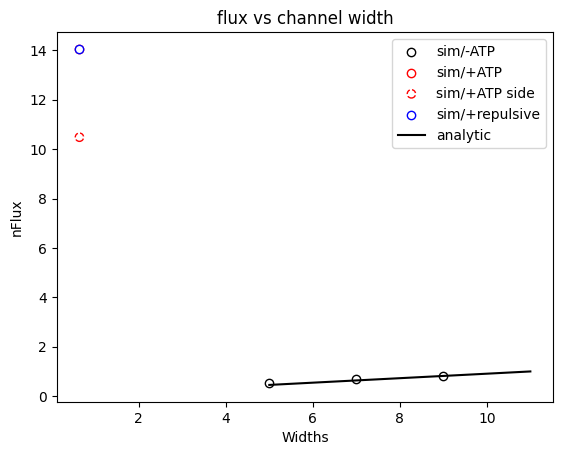

In [ ]:
widths=[5,7,9]
fluxes = np.array([0.059,0.075,0.088])
max=11 # include this in widths next time
print("WARNING: use actual value")
maxFlux = fluxes[2]*max/widths[2]


print("THESE ARE FLUXES, NOT Ds!!!!")
w = np.array([7/11.]) ; print("WARNING: need to verify")
ref =  0.07531812128985557
DsATPEnd = np.array([0.11386163913859533])/ref ; print("WARNING: field and species are both negative/???")

DsATPSide = np.array([0.08490851205509801])/ref ; print("WARNING: field and species are both negative/repulsive???")

DsRepulsiveEnd = np.array([0.06720684392605135])/ref ; print("WARNING: field and species are attractive???")


import matplotlib.pylab as plt
import numpy as np
plt.scatter(widths,fluxes/maxFlux, edgecolor='k', facecolor='w',
            label="sim/-ATP")
plt.scatter(w,DsATPEnd/maxFlux, edgecolor='r', facecolor='w',
            label="sim/+ATP")
plt.scatter(w,DsATPSide/maxFlux, edgecolor='r', facecolor='w',linestyle='--',
            label="sim/+ATP side")
plt.scatter(w,DsATPEnd/maxFlux, edgecolor='b', facecolor='w',
            label="sim/+repulsive")
validwidths = np.array([5,7,9,max])
plt.plot(validwidths,validwidths/max,'k',label='analytic')
plt.ylabel("nFlux")
plt.xlabel("Widths")
plt.title("flux vs channel width")
plt.legend(loc=0)


plt.gcf().savefig(outPath+"fig7_JvsW.png",dpi=300)


In [ ]:
maxFlux

1.0755555555555556

Placeholder figure
\begin{align}
D &\propto e^{-\beta G_a^*} \\
⇒ G_a^* &= -\beta^{-1} \lg D
\end{align}


In [ ]:
import matplotlib.pylab as plt
import numpy as np

In [ ]:
vf = np.linspace(0.06,1,30)
Ds_eps0 = 2*vf/(3-vf)

(0.0, 1.0)

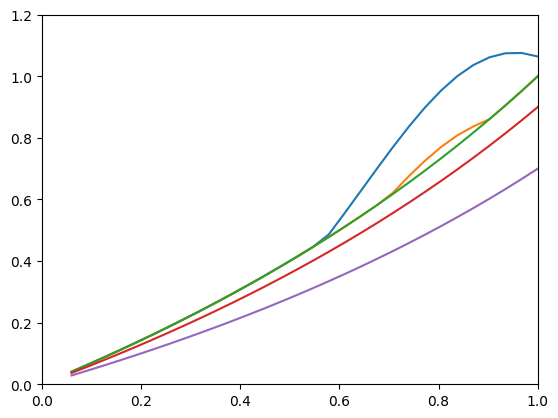

In [ ]:
print("WARNING: PLACEHOLDER DATA ")

def dafunc(vf,scale=1.1):
  Ds_eps0 = 2*vf/(3-vf)

  if scale > 1:
    f = Ds_eps0 * scale*np.exp(- ((vf-0.8)**2)/0.2)
    comb = np.max([Ds_eps0,f],axis=0)
  else  :
    f = Ds_eps0*(1-scale*np.exp(- ((vf-0.8)**2)/0.2))
    comb = f
  return comb

eps = [-1,-0.5,0,0.5,1]
das = np.zeros([5,30])
das[0,:] = dafunc(vf,scale=1.3)
plt.plot(vf,das[0,:]) # -1
das[1,:] = dafunc(vf,scale=1.05)
plt.plot(vf,das[1,:]) # -0.5
das[2,:] = Ds_eps0
plt.plot(vf,das[2,:])
das[3,:] = 0.9*Ds_eps0
plt.plot(vf,das[3,:]) # +0.5
das[4,:] = 0.7*Ds_eps0
plt.plot(vf,das[4,:]) # +1
plt.ylim([0,1.2])
plt.xlim([0,1])

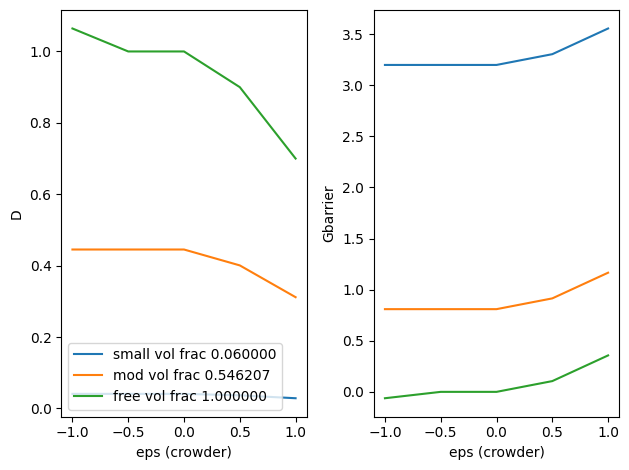

In [ ]:
Dtrans = np.transpose(das)

f, (axl, axr) = plt.subplots(1, 2)
axl.plot(eps,Dtrans[0,:],label="small vol frac %f"%vf[0])
axl.plot(eps,Dtrans[15,:],label="mod vol frac %f"%vf[15])
axl.plot(eps,Dtrans[29,:],label="free vol frac %f"%vf[29])
axl.legend(loc=3)
axl.set_ylabel("D")
axl.set_xlabel("eps (crowder)")

G = - 1 * np.log(Dtrans)
axr.plot(eps,G[0,:])
axr.plot(eps,G[15,:])
axr.plot(eps,G[29,:])
axr.set_ylabel("Gbarrier")
axr.set_xlabel("eps (crowder)")
plt.tight_layout()
plt.gcf().savefig("crowderAttr.png",dpi=300)